# Figure 2: Response of Ross Sea salinity and DSW/AABW to perturbations

In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
import cosima_cookbook as cc
from dask.distributed import Client
import cftime
from gsw import p_from_z, SA_from_SP
import sys
sys.path.append(
    "/g/data/e14/cs6673/Ross_salinity/Python_scripts_published/") 
from Info_definitions import (
    path_database, path_output, path_plots, exptdict, yearly_mean,
    shelf_mask_isobath, select_bottom_values)

import matplotlib.pyplot as plt
import string

In [2]:
plt.rcParams['figure.dpi'] = 96
plt.rcParams["font.size"] = 12
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["lines.linewidth"] = 1.5
plt.rcParams["lines.markersize"] = 3
plt.rcParams['hatch.color'] = 'k'
plt.rcParams["savefig.facecolor"] = 'white'

In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38671,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.19 GiB
Comm: tcp://127.0.0.1:41455,Total threads: 4
Dashboard: /proxy/33537/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:43345,


Exception during reset or similar
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/sqlalchemy/pool/base.py", line 763, in _finalize_fairy
    fairy._reset(pool, transaction_was_reset)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/sqlalchemy/pool/base.py", line 1038, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/sqlalchemy/engine/default.py", line 683, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 22394495850304 and this is thread id 22392985749248.
Exception closing connection <sqlite3.Connection object at 0x145dadab9940>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/sit

## Load data

In [4]:
%%time
ekeys = ['ctrl', 'wind_50_down_zonal', 'mw_50_down']
start_time = '2150-01-01'
end_time = '2159-12-31'

area_t = cc.querying.getvar(
    exptdict['ctrl']['expt'], 'area_t',
    session=cc.database.create_session(), frequency='static',  n=1,
    chunks={'yt_ocean': '200MB', 'xt_ocean': '200MB'}).sel(
    yt_ocean=slice(-76, -71), xt_ocean=slice(-198, -184))

for ekey in ekeys:
    print(ekey)
    e = exptdict[ekey]
    if ekey == 'ctrl':
        session = cc.database.create_session()
    else:
        db = (path_database + e['expt'] + '.db')
        session = cc.database.create_session(db)

    salt = cc.querying.getvar(
        e['expt'], 'salt', session, frequency='1 monthly',
        start_time=start_time, end_time=end_time,
        chunks={'yt_ocean': '200MB', 'xt_ocean': '200MB'}).sel(
            yt_ocean=slice(-76, -71), xt_ocean=slice(-198, -184))
    # convert units to absolute salinity
    pressure = p_from_z(-salt.st_ocean, salt.yt_ocean)
    e['salt'] = SA_from_SP(
        salt, pressure, salt.xt_ocean, salt.yt_ocean).compute()

    e['dzt'] = cc.querying.getvar(
        e['expt'], 'dzt', session, frequency='1 monthly',
        chunks={'yt_ocean': '100MB', 'xt_ocean': '100MB'}).sel(
        yt_ocean=slice(None, -60), xt_ocean=slice(-240, -60))

    e['rho0'] = cc.querying.getvar(
        e['expt'], 'pot_rho_0', session, frequency='1 monthly',
        start_time=start_time, end_time=end_time,
        chunks={'yt_ocean': '200MB', 'xt_ocean': '200MB'}).sel(
            yt_ocean=slice(None, -60), xt_ocean=slice(-240, -60)) - 1000

    # SWMT in southwestern Ross Sea
    ds_SWMT = xr.open_mfdataset(
        path_output + 'SWMT_in_AABW_formation_region_' + e['expt']  +
        '_1m_????.nc')
    ds_SWMT = ds_SWMT.sel(area='Ross').sel(
        time=slice(start_time[:4], end_time[:4]))
    e['swmt'] = yearly_mean(
        ds_SWMT.binned_salt_transformation_in_AABW_region +
        ds_SWMT.binned_heat_transformation_in_AABW_region).compute()
    e['swmt_m'] = (
        ds_SWMT.binned_salt_transformation_in_AABW_region +
        ds_SWMT.binned_heat_transformation_in_AABW_region)

    # Is the SWMT mostly influenced by surface fluxes
    # or the background density field?
    if ekey != 'ctrl':
        ds_SWMT = xr.open_mfdataset(
            path_output + 'SWMT_in_AABW_formation_region_' + e['expt']  +
            '_fluxes_' + exptdict['ctrl']['expt'] + '_rho0_1m_????.nc')
        ds_SWMT = ds_SWMT.sel(area='Ross').sel(
            time=slice(start_time[:4], end_time[:4]))
        e['swmt_ctrl_rho'] = yearly_mean(
            ds_SWMT.binned_salt_transformation_in_AABW_region +
            ds_SWMT.binned_heat_transformation_in_AABW_region).compute()
        e['swmt_ctrl_rho_m'] = (
            ds_SWMT.binned_salt_transformation_in_AABW_region +
            ds_SWMT.binned_heat_transformation_in_AABW_region)

        ds_SWMT = xr.open_mfdataset(
            path_output + 'SWMT_in_AABW_formation_region_' +
            exptdict['ctrl']['expt'] + '_fluxes_' + e['expt'] + 
            '_rho0_1m_????.nc')
        ds_SWMT = ds_SWMT.sel(area='Ross').sel(
            time=slice(start_time[:4], end_time[:4]))
        e['swmt_ctrl_fluxes'] = yearly_mean(
            ds_SWMT.binned_salt_transformation_in_AABW_region +
            ds_SWMT.binned_heat_transformation_in_AABW_region).compute()
        e['swmt_ctrl_fluxes_m'] = (
            ds_SWMT.binned_salt_transformation_in_AABW_region +
            ds_SWMT.binned_heat_transformation_in_AABW_region)

ctrl


Exception during reset or similar
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/sqlalchemy/pool/base.py", line 763, in _finalize_fairy
    fairy._reset(pool, transaction_was_reset)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/sqlalchemy/pool/base.py", line 1038, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/sqlalchemy/engine/default.py", line 683, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 22394495850304 and this is thread id 22392985749248.
Exception closing connection <sqlite3.Connection object at 0x145de00ea940>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/sit

wind_50_down_zonal
mw_50_down
CPU times: user 21.3 s, sys: 6.43 s, total: 27.7 s
Wall time: 54.7 s


## Plots

In [5]:
def Fig_2(ekeys, rho_AABW=27.86, time_slice=slice('2155', '2159')):
    fig = plt.figure(figsize=(12, 12))
    gs = fig.add_gridspec(4, 2, height_ratios=[1.5, 1, .1, 1.8],
                          hspace=.14)
    ax0 = fig.add_subplot(gs[0, :])
    ax1 = fig.add_subplot(gs[1, :])
    ax2 = fig.add_subplot(gs[3, 0])
    ax3 = fig.add_subplot(gs[3, 1])
    axs = [ax0, ax1, ax2, ax3]

    for ekey in ekeys:
        e = exptdict[ekey]
        
        """ a) salinity """
        for area in ['TNB', 'DT']:
            if area == 'TNB':
                # 74.75°S–75.50°S and 163.00°E–166.00°E, 870-900 dbar
                name = 'Terra Nova\nBay'
                if ekey == 'ctrl':
                    ax0.text(.01, .75, name, transform=ax0.transAxes)
                k = 44  # depth index 44 is appr. at depth of obs
                lon_range = [-197, -194]
                lat_range = [-75.5, -74.75]
                linestyle = '-'
            elif area == 'DT':
                # 72.00°S and 72.67°S and 171.50°E and 174.50°E,
                # bottom 20 dbar
                name = 'Drygalski Trough'
                if ekey == 'ctrl':
                    ax0.text(.01, .4, name, transform=ax0.transAxes)
                k = 'bot'
                lon_range = [-188.5, -185.5]
                lat_range = [-72.67, -72]
                linestyle = '--'
    
            salt = e['salt'].sel(
                xt_ocean=slice(lon_range[0], lon_range[1]),
                yt_ocean=slice(lat_range[0], lat_range[1]))
            if k == 'bot':
                salt = select_bottom_values(salt)
            else:
                salt = salt.isel(st_ocean=k)
            area_weight = area_t.sel(
                xt_ocean=slice(lon_range[0], lon_range[1]),
                yt_ocean=slice(lat_range[0], lat_range[1]))
            area_weight = area_weight.where(np.isnan(salt[0, :]) == False)
            area_weight = area_weight/area_weight.sum(
                ['xt_ocean', 'yt_ocean'])
            
            salt = (salt * area_weight).sum(['xt_ocean', 'yt_ocean'])
            
            ax0.plot(np.linspace(0, len(salt.time)/12, len(salt.time)), salt,
                     color=e['col'], label=e['expt_str'], linestyle=linestyle)

        """ b) AABW thickness """
        thickAABW = e['dzt'].sel(
            xt_ocean=slice(-191.5, -189.5), yt_ocean=slice(-70.3, -69))
        thickAABW = yearly_mean(thickAABW.where(e['rho0'] >= rho_AABW).sum(
            'st_ocean').mean(['xt_ocean', 'yt_ocean']))
        ax1.plot(np.arange(len(thickAABW.time)) + .5, thickAABW, marker='o',
                   color=e['col'])

    handles, labels = ax0.get_legend_handles_labels()
    ax0.legend(handles[::2], labels[::2], ncol=len(ekeys),
                 loc='center', bbox_to_anchor=(0.5, 1.08))
    for p in np.arange(len(axs[:-2])):
        axs[p].set_xlim(0, len(thickAABW.time))
        if p == 0:
            axs[p].text(.01, .93, string.ascii_lowercase[p] + ') ',
                       fontweight='bold', transform=axs[p].transAxes)
        else:
            axs[p].text(.01, .89, string.ascii_lowercase[p] + ') ',
                       fontweight='bold', transform=axs[p].transAxes)

    ax1.set_xlabel('Model year')
    ax0.set_ylabel('Absolute salinity (g kg$^{-1}$)')
    ax1.set_ylabel('AABW thickness at\nCape Adare (m)', labelpad=7)


    """ c + d) SWMT """
    ekeys = ekeys[1:]
    
    e = exptdict['ctrl']
    # maximum SWMT of time mean 
    swmt_max = e['swmt'].mean('time')[e['swmt'].mean('time').argmax(
        'isopycnal_bins').values]
    # isopycnal bin corresponding to SWMT 75% and 25% below its maximum value
    swmt_sig_bin_75 = e['swmt'].isopycnal_bins.sel(
        isopycnal_bins=slice(swmt_max.isopycnal_bins, None)).where(
        e['swmt'].mean('time') <= swmt_max*.75).min('isopycnal_bins')
    swmt_sig_bin_25 = e['swmt'].isopycnal_bins.sel(
        isopycnal_bins=slice(swmt_max.isopycnal_bins, None)).where(
        e['swmt'].mean('time') <= swmt_max*.25).min('isopycnal_bins')
    
    for i, ekey in enumerate(ekeys):
        e = exptdict[ekey]
        var_all = ['swmt', 'swmt', 'swmt_ctrl_rho', 'swmt_ctrl_fluxes']
        label_all = [exptdict['ctrl']['expt_str'], e['expt_str'],
                     r'CONTROL $\rho_0$ + ' + e['expt_str'] + ' fluxes',
                     e['expt_str'] + r' $\rho_0$ + CONTROL fluxes']
        col_all = [exptdict['ctrl']['col'], e['col'], 'silver', 'gold']
        ls_all = ['-', '-', (0, (3, 4)), (0, (3, 4))]
        lw_all = [2, 2, 2.5, 2.5]
        for p, var in enumerate(var_all):
            if p == 0:
                axs[i+2].axhline(swmt_sig_bin_25, color='k', linewidth=.7)
                axs[i+2].axhline(swmt_sig_bin_75, color='k', linewidth=.7)
                swmt = exptdict['ctrl'][var].sel(time=time_slice)
            else:
                swmt = e[var].sel(time=time_slice)
            swmt = swmt.mean('time')
            swmt_DSW = swmt.sel(isopycnal_bins=slice(
                swmt_sig_bin_75, swmt_sig_bin_25)).mean('isopycnal_bins')
            if p < 2:
                axs[i+2].plot(
                    swmt_DSW, (swmt_sig_bin_25 + swmt_sig_bin_75)/2, 's',
                    color=col_all[p], markersize=6)
            # apply rolling mean as sigma bin spacing is very high now
            swmt = swmt.rolling(isopycnal_bins=4, center=True).mean()
            axs[i+2].plot(
                swmt, swmt.isopycnal_bins, color=col_all[p],
                linestyle=ls_all[p], linewidth=lw_all[p], label=label_all[p])
            
        axs[i+2].set_ylim(28.2, 27.4)
        axs[i+2].set_xlim(0, 2.6)
        axs[i+2].set_title(
            string.ascii_lowercase[i+2] + ') ' + e['expt_str'],
            loc='left', fontweight='bold')
    
        axs[i+2].legend(loc='upper right')
        axs[i+2].set_xlabel('Surface water mass transformation (Sv)')
    ax2.set_ylabel('Potential density $\sigma_0\,$(kg$\,$m$^{-3}$)',
                   labelpad=15)
    ax3.set_ylabel('Potential density $\sigma_0\,$(kg$\,$m$^{-3}$)')
    
    # plt.savefig(path_plots + 'Fig2.png', dpi=300, bbox_inches="tight")
    plt.show()

In [6]:
def Fig_S2(ekeys, region='Cape Adare', rho_AABW=np.arange(27.85, 27.88, .01)):
    fig = plt.figure(figsize=(12, len(rho_AABW)*1.2))
    plt.subplots_adjust(wspace=.12)

    """ sensitivity of AABW thickness to density threshold """

    for r in range(len(rho_AABW)):
        plt.subplot(int(len(rho_AABW)/2), 2, r+1)
        for ekey in ekeys:
            e = exptdict[ekey]
            if region == 'Cape Adare':
                thickAABW = e['dzt'].sel(
                    xt_ocean=slice(-191.5, -189.5), yt_ocean=slice(-70.3, -69))
            elif region == 'ABB':
                # Amundsen-Bellingshausen Basin
                thickAABW = e['dzt'].sel(
                    xt_ocean=slice(-172, -165), yt_ocean=slice(-71, -69))
            thickAABW = yearly_mean(
                thickAABW.where(e['rho0'] >= rho_AABW[r]).sum('st_ocean').mean(
                ['xt_ocean', 'yt_ocean']))
            plt.plot(np.arange(len(thickAABW.time)) + .5, thickAABW, marker='o',
                     color=e['col'], label=e['expt_str'])
        if r == 0:
            plt.legend(ncol=len(ekeys), loc='center', bbox_to_anchor=(1.05, 1.12))
        plt.xlim(0, len(thickAABW.time))
        plt.text(.01, .89, string.ascii_lowercase[r] + ') ' + r'$\sigma_0\geq$' +
                 str(np.round(rho_AABW[r], 2)),
                 fontweight='bold', transform=plt.gca().transAxes)
        if r > 1:
            plt.xlabel('Model year')        
    fig.supylabel('AABW thickness at Cape Adare (m)', fontsize=12, x=.065)
    
    # plt.savefig(path_plots + 'FigS2.png', dpi=300, bbox_inches="tight")

    plt.show()

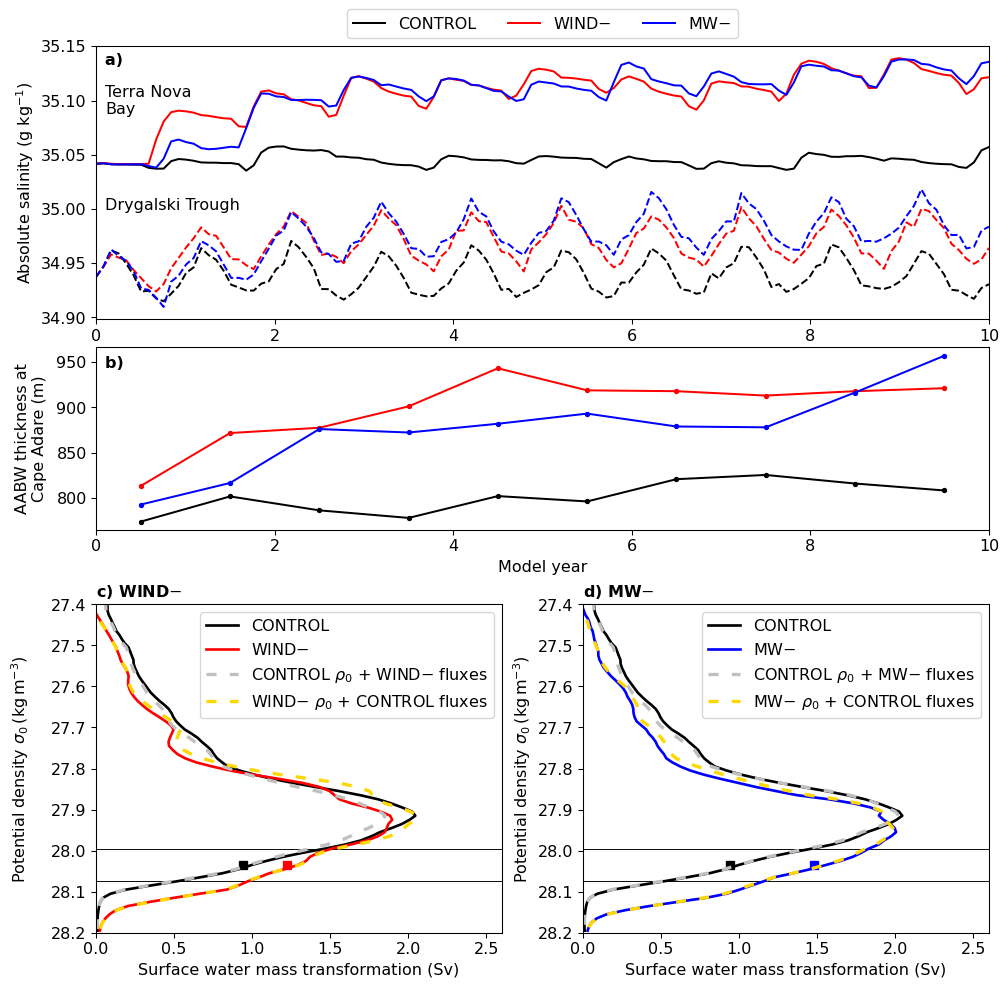

In [7]:
Fig_2(ekeys, rho_AABW=27.86, time_slice=slice('2155', '2159'))

In [8]:
time_slice = slice('2155', '2159')
print('Mean SWMT in ' + time_slice.start + '-' + time_slice.stop)
for ekey in ekeys:
    e = exptdict[ekey]
    if ekey == 'ctrl':
        # maximum SWMT of time mean 
        swmt_max = e['swmt'].mean('time')[e['swmt'].mean('time').argmax(
            'isopycnal_bins').values]
        # isopycnal bin corresponding to SWMT 75% and 25% below its maximum value
        swmt_sig_bin_75 = e['swmt'].isopycnal_bins.sel(
            isopycnal_bins=slice(swmt_max.isopycnal_bins, None)).where(
            e['swmt'].mean('time') <= swmt_max*.75).min('isopycnal_bins')
        swmt_sig_bin_25 = e['swmt'].isopycnal_bins.sel(
            isopycnal_bins=slice(swmt_max.isopycnal_bins, None)).where(
            e['swmt'].mean('time') <= swmt_max*.25).min('isopycnal_bins')

    swmt = e['swmt'].sel(isopycnal_bins=slice(
        swmt_sig_bin_75, swmt_sig_bin_25)).mean('isopycnal_bins')
    if ekey == 'ctrl':
        swmt_ctrl = swmt.sel(time=time_slice).mean('time').values
        print(ekey, ':', np.round(swmt_ctrl, 2), ' Sv')
    else:
        swmt = swmt.sel(time=time_slice).mean('time').values
        print(ekey, ':', np.round(swmt, 2), ' Sv (+',
              np.round((swmt-swmt_ctrl)/swmt_ctrl*100, 1), '%)')

"""Salinity"""
for area in ['TNB', 'DT']:
    if area == 'TNB':
        # 74.75°S–75.50°S and 163.00°E–166.00°E, 870-900 dbar
        name = 'Terra Nova Bay'
        k = 44  # depth index 44 is appr. at depth of obs
        lon_range = [-197, -194]
        lat_range = [-75.5, -74.75]
        linestyle = '-'
    elif area == 'DT':
        # 72.00°S and 72.67°S and 171.50°E and 174.50°E, bottom 20 dbar
        name = 'Drygalski Trough'
        k = 'bot'
        lon_range = [-188.5, -185.5]
        lat_range = [-72.67, -72]
        linestyle = '--'
    print('')
    print('Mean salinity in ' + name + ' in ' + time_slice.start +
          '-' + time_slice.stop)

    for ekey in ekeys:
        e = exptdict[ekey]

        salt = e['salt'].sel(
            xt_ocean=slice(lon_range[0], lon_range[1]),
            yt_ocean=slice(lat_range[0], lat_range[1]))
        if k == 'bot':
            salt = select_bottom_values(salt)
        else:
            salt = salt.isel(st_ocean=k)
        area_weight = area_t.sel(
            xt_ocean=slice(lon_range[0], lon_range[1]),
            yt_ocean=slice(lat_range[0], lat_range[1]))
        area_weight = area_weight.where(np.isnan(salt[0, :]) == False)
        area_weight = area_weight/area_weight.sum(['xt_ocean', 'yt_ocean'])
        
        salt = (salt * area_weight).sum(['xt_ocean', 'yt_ocean'])
        if ekey == 'ctrl':
            salt_ctrl = yearly_mean(salt.sel(
                time=time_slice)).mean('time').values
            print(ekey, ':', np.round(salt_ctrl, 3), ' g/kg')
        else:
            salt = yearly_mean(salt.sel(time=time_slice)).mean('time').values
            print(ekey, ':', np.round(salt, 3), ' g/kg (+',
                  np.round((salt-salt_ctrl), 3), 'g/kg)')

print('')
print('AABW thickness at Cape Adare in ' + time_slice.start +
      '-' + time_slice.stop)
rho_AABW = 27.86
for ekey in ekeys:
    e = exptdict[ekey]
    thickAABW = e['dzt'].sel(
        xt_ocean=slice(-191.5, -189.5), yt_ocean=slice(-70.3, -69))
    thickAABW = yearly_mean(thickAABW.where(e['rho0'] >= rho_AABW).sum(
        'st_ocean').mean(['xt_ocean', 'yt_ocean'])).sel(
        time=time_slice).mean('time').values
    print(ekey, ':', np.int(thickAABW), 'm')

Mean SWMT in 2155-2159
ctrl : 0.94  Sv
wind_50_down_zonal : 1.22  Sv (+ 29.8 %)
mw_50_down : 1.48  Sv (+ 57.6 %)

Mean salinity in Terra Nova Bay in 2155-2159
ctrl : 35.044  g/kg
wind_50_down_zonal : 35.118  g/kg (+ 0.074 g/kg)
mw_50_down : 35.121  g/kg (+ 0.077 g/kg)

Mean salinity in Drygalski Trough in 2155-2159
ctrl : 34.94  g/kg
wind_50_down_zonal : 34.972  g/kg (+ 0.032 g/kg)
mw_50_down : 34.984  g/kg (+ 0.045 g/kg)

AABW thickness at Cape Adare in 2155-2159
ctrl : 813 m
wind_50_down_zonal : 917 m
mw_50_down : 904 m


In [9]:
time_slice = slice('2155', '2159')
print('Mean SWMT in ' + time_slice.start + '-' + time_slice.stop)
print('')
print('Density thresholds based on CONTROL')
for ekey in ekeys:
    e = exptdict[ekey]
    if ekey == 'ctrl':
        # maximum SWMT of time mean 
        swmt_max = e['swmt'].mean('time')[e['swmt'].mean(
            'time').argmax('isopycnal_bins').values]
        # isopycnal bin corresponding to SWMT 75% and 25%
        # below its maximum value
        swmt_sig_bin_75 = e['swmt'].isopycnal_bins.sel(
            isopycnal_bins=slice(swmt_max.isopycnal_bins, None)).where(
            e['swmt'].mean('time') <= swmt_max*.75).min('isopycnal_bins')
        swmt_sig_bin_25 = e['swmt'].isopycnal_bins.sel(
            isopycnal_bins=slice(swmt_max.isopycnal_bins, None)).where(
            e['swmt'].mean('time') <= swmt_max*.25).min('isopycnal_bins')

    swmt = e['swmt'].sel(isopycnal_bins=slice(
        swmt_sig_bin_75, swmt_sig_bin_25)).mean('isopycnal_bins')
    if ekey == 'ctrl':
        swmt_ctrl = swmt.sel(time=time_slice).mean('time').values
        print(ekey, ':', np.round(swmt_ctrl, 2), ' Sv')
    else:
        swmt = swmt.sel(time=time_slice).mean('time').values
        print(ekey, ':', np.round(swmt, 2), ' Sv (+',
              np.round((swmt-swmt_ctrl), 2), ' Sv, +',
              np.round((swmt-swmt_ctrl)/swmt_ctrl*100, 1), '%)')

print('')
print('Density thresholds based on WIND-')
e = exptdict['wind_50_down_zonal']
# maximum SWMT of time mean 
swmt_max = e['swmt'].mean('time')[e['swmt'].mean('time').argmax(
    'isopycnal_bins').values]
# isopycnal bin corresponding to SWMT 75% and 25% below its maximum value
swmt_sig_bin_75 = e['swmt'].isopycnal_bins.sel(
    isopycnal_bins=slice(swmt_max.isopycnal_bins, None)).where(
    e['swmt'].mean('time') <= swmt_max*.75).min('isopycnal_bins')
swmt_sig_bin_25 = e['swmt'].isopycnal_bins.sel(
    isopycnal_bins=slice(swmt_max.isopycnal_bins, None)).where(
    e['swmt'].mean('time') <= swmt_max*.25).min('isopycnal_bins')
for ekey in ekeys:
    e = exptdict[ekey]
    swmt = e['swmt'].sel(isopycnal_bins=slice(
        swmt_sig_bin_75, swmt_sig_bin_25)).mean('isopycnal_bins')
    if ekey == 'ctrl':
        swmt_ctrl = swmt.sel(time=time_slice).mean('time').values
        print(ekey, ':', np.round(swmt_ctrl, 2), ' Sv')
    else:
        swmt = swmt.sel(time=time_slice).mean('time').values
        print(ekey, ':', np.round(swmt, 2), ' Sv (+',
              np.round((swmt-swmt_ctrl), 2), ' Sv, +',
              np.round((swmt-swmt_ctrl)/swmt_ctrl*100, 1), '%)')

print('')
print('Density thresholds based on MW-')
e = exptdict['mw_50_down']
# maximum SWMT of time mean 
swmt_max = e['swmt'].mean('time')[e['swmt'].mean('time').argmax(
    'isopycnal_bins').values]
# isopycnal bin corresponding to SWMT 75% and 25% below its maximum value
swmt_sig_bin_75 = e['swmt'].isopycnal_bins.sel(
    isopycnal_bins=slice(swmt_max.isopycnal_bins, None)).where(
    e['swmt'].mean('time') <= swmt_max*.75).min('isopycnal_bins')
swmt_sig_bin_25 = e['swmt'].isopycnal_bins.sel(
    isopycnal_bins=slice(swmt_max.isopycnal_bins, None)).where(
    e['swmt'].mean('time') <= swmt_max*.25).min('isopycnal_bins')
for ekey in ekeys:
    e = exptdict[ekey]
    swmt = e['swmt'].sel(isopycnal_bins=slice(
        swmt_sig_bin_75, swmt_sig_bin_25)).mean('isopycnal_bins')
    if ekey == 'ctrl':
        swmt_ctrl = swmt.sel(time=time_slice).mean('time').values
        print(ekey, ':', np.round(swmt_ctrl, 2), ' Sv')
    else:
        swmt = swmt.sel(time=time_slice).mean('time').values
        print(ekey, ':', np.round(swmt, 2), ' Sv (+',
              np.round((swmt-swmt_ctrl), 2), ' Sv, +',
              np.round((swmt-swmt_ctrl)/swmt_ctrl*100, 1), '%)')

Mean SWMT in 2155-2159

Density thresholds based on CONTROL
ctrl : 0.94  Sv
wind_50_down_zonal : 1.22  Sv (+ 0.28  Sv, + 29.8 %)
mw_50_down : 1.48  Sv (+ 0.54  Sv, + 57.6 %)

Density thresholds based on WIND
ctrl : 0.68  Sv
wind_50_down_zonal : 1.05  Sv (+ 0.37  Sv, + 54.4 %)
mw_50_down : 1.31  Sv (+ 0.63  Sv, + 92.7 %)

Density thresholds based on MW
ctrl : 0.41  Sv
wind_50_down_zonal : 0.84  Sv (+ 0.43  Sv, + 106.2 %)
mw_50_down : 1.06  Sv (+ 0.66  Sv, + 162.4 %)


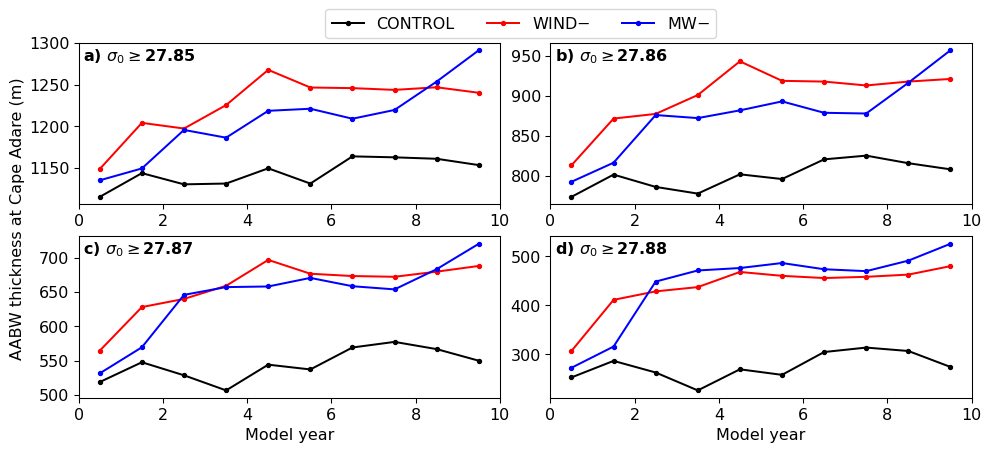

In [10]:
Fig_S2(ekeys, region='Cape Adare', rho_AABW=np.arange(27.85, 27.89, .01))